This Jupyter notebook presents the initial exploration of evaluation framework used to validate the quality and privacy of synthetically generated data.

## Testing Synthetic Data Validity

Three elements to evaluate
    1) Utility
    2) Fidelity
    3) Privacy

In [15]:
## if you want to run the initial ctgan model
!pip install --no-user "sdv==1.23" "numpy==1.26.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 32.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.2
    Uninstalling numpy-2.3.2:
      Successfully uninstalled numpy-2.3.2


In [1]:
# loading ctgan
from sdv.single_table import CTGANSynthesizer

# Loading the model from the pickle file
ctgan = CTGANSynthesizer.load(
    filepath='models/ctgan.pkl'
)

/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/sdv/_utils.py:500: FutureWarning:

The 'load' function will be deprecated in future versions of SDV. Please use 'utils.load_synthesizer' instead.



In [2]:
# importing metadata
import pandas as pd
from sdv.metadata import Metadata

# Load from a saved JSON file
metadata = Metadata.load_from_json('my_final_metadata_v2.json')
metadata_dict = metadata.to_dict() if hasattr(metadata, "to_dict") else metadata

In [3]:
# loading data
import pandas as pd
df_filtered = pd.read_pickle("filtered_data/df_v2_filtered.pkl")

In [4]:
len(df_filtered)

1340347

In [5]:
# Generating synthetic data
synthetic_data = ctgan.sample(
    num_rows= 1340347
, # generating the same number of data points as the real dataset
    batch_size=1_000
)

Sampling rows: : 1341000it [01:48, 12392.04it/s]                           


In [8]:
# Loading real data
import sys
import numpy.core.numeric as core_numeric
import types

# Create a dummy module named "numpy._core.numeric"
shim = types.ModuleType("numpy._core.numeric")
shim.__dict__.update(core_numeric.__dict__)
sys.modules["numpy._core.numeric"] = shim

import pickle
with open('processed_data_v1.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
# Removing unnecessary columns
df = df.drop(['incident_count','datazone', 'dzone_code'], axis=1)

In [4]:
# covert bool vars to cat
bool_vars = ['scrs_crime_inc', 'inc_resourced']
df[bool_vars] = df[bool_vars].astype('category')

In [5]:
# converting date variable to a number in [startdate, enddate]
import pandas as pd

# make sure date_created is datetime
df['date_created'] = pd.to_datetime(df['date_created'])

# compute day offset from min date, then +1
min_date = df['date_created'].min()  # 2022-04-01 00:00:00
df['date_seq'] = (df['date_created'] - min_date).dt.days + 1

# compute min/max of each
min_date = df['date_created'].min()
max_date = df['date_created'].max()
min_seq  = df['date_seq'].min()
max_seq  = df['date_seq'].max()

# grab the corresponding dates from the mapped column
mapped_min_date = df.loc[df['date_seq'] == min_seq, 'date_created'].iloc[0]
mapped_max_date = df.loc[df['date_seq'] == max_seq, 'date_created'].iloc[0]

# sanity‐check
print(f"earliest actual date: {min_date}, mapped date at seq {min_seq}: {mapped_min_date}")
print(f" latest actual date: {max_date}, mapped date at seq {max_seq}: {mapped_max_date}")

earliest actual date: 2022-04-01 00:00:00, mapped date at seq 1: 2022-04-01 00:00:00
 latest actual date: 2025-03-31 00:00:00, mapped date at seq 1096: 2025-03-31 00:00:00


In [6]:
df = df.drop('date_created', axis=1)
df.head()

,hour_created,max_final_priority,inc_resourced,scrs_crime_inc,multi_member_ward,service_code_description,date_seq
0,7,PROMPT,False,False,Dennistoun,ROAD TRAFFIC COLLISION,498
1,20,PROMPT,True,False,Lochee,ASSIST MEMBER OF THE PUBLIC,322
2,0,STANDARD,False,True,Leith Walk,THEFT,889
3,14,PROMPT,True,False,Almond,EXTERNAL AGENCY REQUEST,886
4,19,PROMPT,True,False,Paisley North West,EXTERNAL AGENCY REQUEST,12


In [7]:
# The aim is to filter data to get only incidents that are classified as THEFT
df_cleaned = df.copy()
dft = df_cleaned[df_cleaned['service_code_description'] == 'THEFT']

In [8]:
# Loading synthetic data
from sdv.single_table import CTGANSynthesizer

# Loading the model from the pickle file
ctgan = CTGANSynthesizer.load(
    filepath='ctgan_theft.pkl'
)

# Generating synthetic data
synthetic_data = ctgan.sample(
    num_rows= 182229, # generating the same number of data points as the real dataset
    batch_size=1_000
)

Sampling rows: : 183000it [00:05, 33068.46it/s]                          


In [9]:
# If you want to convert all object columns to category
for col in dft.select_dtypes(include='object').columns:
    dft[col] = dft[col].astype('category')

In [10]:
# Loading metadata
import json

with open('my_final_metadata.json', 'r') as f:
    metadata = json.load(f)

## Diagnostic Metrics

These metrics are not really informative. Data Structure measures whether the synthetic data captures the same table structure as the real data. We expect the synthetic data to have the same column names as the real data, and for those columns to have the same data storage type (ints, strings, etc.).

In [32]:
from sdmetrics.reports.single_table import DiagnosticReport
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Generate the diagnostic report
report = DiagnosticReport()
report.generate(dft, synthetic_data, metadata['tables']['incidents'])

# Get the overall diagnostic score (between 0 and 1)
overall_score = report.get_score()
print(f"Overall diagnostic score: {overall_score}")

# Get the individual property scores
properties = report.get_properties()
print("Property scores:", properties)

# Get detailed scores for 'Data Validity'
details_validity = report.get_details(property_name='Data Validity')
print("Data Validity Details:\n", details_validity)

# Get detailed scores for 'Data Structure'
details_structure = report.get_details(property_name='Data Structure')
print("Data Structure Details:\n", details_structure)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 7/7 [00:00<00:00, 72.99it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 832.04it/s]|
Data Structure Score: 16.67%

Overall Score (Average): 58.33%

Overall diagnostic score: 0.5833333333333334
Property scores:          Property     Score
0   Data Validity  1.000000
1  Data Structure  0.166667
Data Validity Details:
                      Column             Metric  Score
0              hour_created  BoundaryAdherence    1.0
1        max_final_priority  CategoryAdherence    1.0
2             inc_resourced  CategoryAdherence    1.0
3            scrs_crime_inc  CategoryAdherence    1.0
4         multi_member_ward  CategoryAdherence    1.0
5  service_code_description  CategoryAdherence    1.0
6                  date_seq  BoundaryAdherence    1.0
Data Structure Details:
            Metric     Score
0  TableStructure  0.166667


## Fidelity

### Hellingers Distance

In [5]:
dft_copy = df_filtered.copy()
synthetic_data_copy = synthetic_data.copy()

In [6]:
# Changing datatype from object -> category
object_cols = synthetic_data_copy.select_dtypes(include='object').columns
synthetic_data_copy[object_cols] = synthetic_data_copy[object_cols].astype('category')

In [7]:
## Hellingers Distance
import numpy as np
from collections import Counter

def hellinger_categorical(a, b):
    counter_a = Counter(a)
    counter_b = Counter(b)
    all_keys = set(counter_a) | set(counter_b)
    total_a, total_b = len(a), len(b)
    p = np.array([counter_a.get(k, 0)/total_a for k in all_keys])
    q = np.array([counter_b.get(k, 0)/total_b for k in all_keys])
    return np.linalg.norm(np.sqrt(p) - np.sqrt(q)) / np.sqrt(2)

def hellinger_numerical(a, b, bins=10):
    counts_a, edges = np.histogram(a, bins=bins, density=True)
    counts_b, _ = np.histogram(b, bins=edges, density=True)
    p = counts_a / counts_a.sum()
    q = counts_b / counts_b.sum()
    return np.linalg.norm(np.sqrt(p) - np.sqrt(q)) / np.sqrt(2)

In [8]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

def hellinger(p, q):
    # Normalize to probability distributions
    p = np.asarray(p, dtype=np.float64)
    q = np.asarray(q, dtype=np.float64)
    p = p / p.sum()
    q = q / q.sum()
    return np.linalg.norm(np.sqrt(p) - np.sqrt(q)) / np.sqrt(2)

def compare_columns(real: pd.DataFrame, synth: pd.DataFrame, bins=10):
    distances = {}
    for col in real.columns:
        if real[col].dtype == 'object' or pd.api.types.is_categorical_dtype(real[col]):
            # Categorical column
            categories = list(set(real[col].unique()) | set(synth[col].unique()))
            real_counts = real[col].value_counts(normalize=True).reindex(categories, fill_value=0)
            synth_counts = synth[col].value_counts(normalize=True).reindex(categories, fill_value=0)
            dist = hellinger(real_counts.values, synth_counts.values)
        else:
            # Numerical column
            col_min = min(real[col].min(), synth[col].min())
            col_max = max(real[col].max(), synth[col].max())
            bin_edges = np.linspace(col_min, col_max, bins + 1)
            real_hist, _ = np.histogram(real[col], bins=bin_edges)
            synth_hist, _ = np.histogram(synth[col], bins=bin_edges)
            dist = hellinger(real_hist, synth_hist)
        distances[col] = dist
    return distances
    
results = compare_columns(dft_copy, synthetic_data_copy, bins=10)

In [9]:
for key,val in results.items():
    print(f"{key}:{val}")

hour_created:0.04357984868682331
max_final_priority:0.05788409107954662
inc_resourced:0.07091197094267492
scrs_crime_inc:0.05928051968458384
service_code_description:0.14541702808547163
multi_member_ward:0.122585802791187
date_seq:0.02572477787386984


In [24]:
## Why multivariate hellingers distance is not feasible to caluclate
cols = dft_copy.columns
real_tuples = list(map(tuple, dft_copy[cols].astype(str).values))
synth_tuples = list(map(tuple, synthetic_data_copy[cols].astype(str).values))
# All possible bins encountered in either dataset
all_bins = list(set(real_tuples) | set(synth_tuples))

# number of column combination for evaluating the multivariate distribution
len(all_bins)

349987

### TSTR

In [3]:
# loading data
import pandas as pd

df_filtered = pd.read_pickle("filtered_data/df_v2_filtered.pkl")

In [4]:
from sklearn.model_selection import train_test_split

# Split into 80% train and 20% test
train_df, test_df = train_test_split(df_filtered, test_size=0.2, random_state=42)

# Reset indices
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [5]:
total = len(df_filtered)
print("Train set size:", len(train_df), f"({len(train_df)/total:.1%})")
print("Test set size:", len(test_df), f"({len(test_df)/total:.1%})")

Train set size: 1072277 (80.0%)
Test set size: 268070 (20.0%)


In [6]:
from sdv.metadata import Metadata

# 1. auto-detect metadata based in your data
metadata = Metadata.detect_from_dataframes({"incidents":train_df})

# 2. carefully inspect and update your metadata
metadata.visualize()

metadata.validate()

# 3. when you're done, save it to a file for future use
# metadata.save_to_json('my_final_metadata_tstr.json')

In [ ]:
from sdv.single_table import CTGANSynthesizer
ctgan = CTGANSynthesizer(
    metadata,
    epochs=800,
    batch_size=1024,
    pac=8,
    embedding_dim=128,
    generator_dim=(256, 256),
    discriminator_dim=(256, 256),
    generator_lr=2e-4,
    discriminator_lr=2e-4,
    cuda=True,
    verbose=True
)
ctgan.fit(train_df)   

/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/sdv/single_table/base.py:128: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.

/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/sdv/single_table/ctgan.py:252: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [ ]:
syn_df = ctgan.sample(len(train_df))

In [ ]:
# Saving the model to a pickle file
ctgan.save(
    filepath='models/ctgan_theft_v8_800epochs_tsrt.pkl'
)

In [ ]:
target_col = 'inc_resourced'                       # ❸ rename to your real target
categorical_cols = [
    col for col in syn_df.columns
    if (syn_df[col].dtype == 'object' or syn_df[col].dtype.name == 'category')
       and col != target_col
]

# Ensure every categorical column is pandas "category" dtype in **both** sets
for col in categorical_cols:
    combined = pd.concat([syn_df[col], test_df[col]], axis=0)
    unified  = pd.Categorical(combined)
    syn_df[col]  = unified[:len(syn_df)].astype('category')
    test_df[col] = unified[len(syn_df):].astype('category')

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score,
    classification_report, confusion_matrix
)

X_syn   = syn_df.drop(columns=[target_col])
y_syn   = syn_df[target_col]

X_test  = test_df.drop(columns=[target_col])
y_test  = test_df[target_col]

lgbm = LGBMClassifier(
    objective='bianary',
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    random_state=42
)

In [ ]:
lgbm.fit(
    X_syn, y_syn,
    categorical_feature=categorical_cols
)

In [ ]:
y_pred       = lgbm.predict(X_test)
y_pred_proba = lgbm.predict_proba(X_test)[:, 1]

print("=== TSTR evaluation (train: synthetic, test: real) ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_pred_proba))
print("F1-score :", f1_score(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nDetailed report:\n", classification_report(y_test, y_pred))

## Utility

In [10]:
# Creating copies of dfs
# dft_copy = dft.copy()
synthetic_data_copy = synthetic_data.copy()

dft_copy["is_real"]          = 1        # positive class
synthetic_data_copy["is_real"] = 0        # negative class

full = pd.concat([dft_copy, synthetic_data_copy], ignore_index=True)

In [11]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Assuming 'full' is your combined DataFrame from the prompt

# Define features (X) and target (y)
X = full.drop('is_real', axis=1)
y = full['is_real']

# Convert object columns to the 'category' dtype for LightGBM
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

# Split data for training and testing the classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize and train the LightGBM classifier
lgbm = lgb.LGBMClassifier(objective='binary', random_state=42)
lgbm.fit(X_train, y_train)

# Get propensity scores for the entire dataset
# The [:, 1] selects the probability of the positive class (is_real=1)
full['p_score'] = lgbm.predict_proba(X)[:, 1]

# Display the scores for real vs. synthetic data
print(full.groupby('is_real')['p_score'].describe())

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 938243, number of negative: 938242
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 707
[LightGBM] [Info] Number of data points in the train set: 1876485, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000001
[LightGBM] [Info] Start training from score 0.000001
             count      mean       std       min       25%       50%  \
is_real                                                                
0        1340347.0  0.398503  0.185454  0.003240  0.261745  0.40158

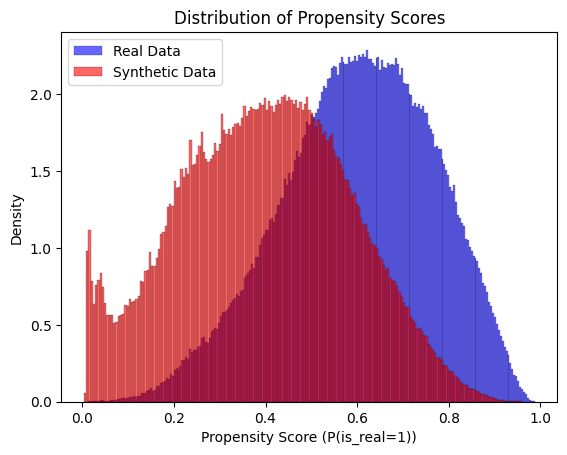

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Separate the scores for real and synthetic data
real_scores = full[full['is_real'] == 1]['p_score']
synthetic_scores = full[full['is_real'] == 0]['p_score']

# Plot the distributions
sns.histplot(real_scores, color="blue", label='Real Data', stat='density', alpha=0.6)
sns.histplot(synthetic_scores, color="red", label='Synthetic Data', stat='density', alpha=0.6)

plt.legend()
plt.title('Distribution of Propensity Scores')
plt.xlabel('Propensity Score (P(is_real=1))')
plt.show()

### Other Metrics

In [14]:
# -----------------------------------------------------------------------
# 0.  Imports
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics.pairwise import pairwise_kernels, pairwise_distances         # ← canonical path :contentReference[oaicite:0]{index=0}

from scipy.spatial.distance import jensenshannon

# SDMetrics 0.12+ : QualityReport lives in the single-table sub-module
from sdmetrics.reports.single_table import QualityReport   # ← per official docs :contentReference[oaicite:1]{index=1}

# -----------------------------------------------------------------------
# 1.  Helper: Maximum Mean Discrepancy  (Gaussian kernel, median heuristic)
# -----------------------------------------------------------------------
def _mmd2_gaussian(X, Y, subsample=None):
    """
    Unbiased estimate of MMD² between X and Y with an RBF kernel.
    """
    rng = np.random.default_rng(42)
    if subsample and (len(X) > subsample):
        X = X[rng.choice(len(X), subsample, replace=False)]
    if subsample and (len(Y) > subsample):
        Y = Y[rng.choice(len(Y), subsample, replace=False)]

    Z = np.vstack([X, Y])

    # 1⃣  Use pairwise_distances for Euclidean matrix
    dists = pairwise_distances(Z, metric='euclidean')

    # 2⃣  Median heuristic for γ
    gamma = 1.0 / (2.0 * np.median(dists[dists > 0]) ** 2)

    # 3⃣  RBF kernels with that γ
    Kxx = pairwise_kernels(X, X, metric='rbf', gamma=gamma)
    Kyy = pairwise_kernels(Y, Y, metric='rbf', gamma=gamma)
    Kxy = pairwise_kernels(X, Y, metric='rbf', gamma=gamma)

    return Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()

# -----------------------------------------------------------------------
# 2.  Prepare numeric matrix for MMD (encode categoricals, scale 0-1)
# -----------------------------------------------------------------------
def _prep_for_mmd(df, cat_cols):
    num_cols = [c for c in df.columns if c not in cat_cols]
    enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    df_enc = df.copy()

    if cat_cols:
        df_enc[cat_cols] = enc.fit_transform(df[cat_cols])

    scaler = MinMaxScaler()
    df_enc[num_cols + cat_cols] = scaler.fit_transform(df_enc[num_cols + cat_cols])
    return df_enc[num_cols + cat_cols].to_numpy()

# ------- identify categorical columns consistently in both tables -------
cat_cols = [
    c for c in df_filtered.columns
    if df_filtered[c].dtype == 'object' or str(df_filtered[c].dtype).startswith('category')
]

X_real  = _prep_for_mmd(df_filtered, cat_cols)
X_synth = _prep_for_mmd(synthetic_data, cat_cols)

mmd2 = _mmd2_gaussian(X_real, X_synth, subsample=20000)   # tweak subsample if memory tight
print(f"✅  MMD²  = {mmd2:.6f}   (lower → closer)")

# -----------------------------------------------------------------------
# 3.  Jensen–Shannon divergence – per column, then average
# -----------------------------------------------------------------------
def _js_col(real_col, synth_col, bins=30):
    if pd.api.types.is_numeric_dtype(real_col):
        hist_r, bin_edges = np.histogram(real_col, bins=bins, density=True)
        hist_s, _         = np.histogram(synth_col, bins=bin_edges, density=True)
    else:                                   # categorical
        cats = pd.Series(list(set(real_col) | set(synth_col)))
        hist_r = real_col.value_counts(normalize=True).reindex(cats, fill_value=0).values
        hist_s = synth_col.value_counts(normalize=True).reindex(cats, fill_value=0).values
    return jensenshannon(hist_r, hist_s, base=2) ** 2      # JS distance → divergence

js_scores = {
    col: _js_col(df_filtered[col], synthetic_data[col])
    for col in df_filtered.columns
}
print(f"✅  Jensen–Shannon divergence  (mean over columns)  = {np.mean(list(js_scores.values())):.6f}")
# Optional: inspect per-column divergences
# pd.Series(js_scores).sort_values(ascending=False).head()

# -----------------------------------------------------------------------
# 4.  KSComplement / TVComplement via SDMetrics QualityReport
# -----------------------------------------------------------------------
qr = QualityReport()
from sdv.metadata import SingleTableMetadata
from sdmetrics.reports.single_table import QualityReport

# 1️⃣  Auto-detect metadata from the real DataFrame
auto_meta = SingleTableMetadata()
auto_meta.detect_from_dataframe(df_filtered)   # df_filtered is your real table
metadata_dict = auto_meta.to_dict()            # <-- has top-level 'columns'

# 2️⃣  Run the report
qr = QualityReport()
qr.generate(
    real_data=df_filtered,
    synthetic_data=synthetic_data,
    metadata=metadata_dict
)
print("Overall quality score:", qr.get_score())
quality_score = qr.get_score()
print(f"✅  SDMetrics QualityReport overall score = {quality_score:.3f}")

# Detailed per-column shape scores (includes KSComplement & TVComplement)
# shape_details = qr.get_details(property_name='Column Shapes')
# print(shape_details[['Column', 'Metric', 'Score']].head())

✅  MMD²  = 0.005615   (lower → closer)
✅  Jensen–Shannon divergence  (mean over columns)  = 0.010413
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 7/7 [00:02<00:00,  2.42it/s]|
Column Shapes Score: 92.22%

(2/2) Evaluating Column Pair Trends: |██████████| 21/21 [00:02<00:00,  9.35it/s]|
Column Pair Trends Score: 85.25%

Overall Score (Average): 88.73%

Overall quality score: 0.8873498324321412
✅  SDMetrics QualityReport overall score = 0.887


## Privacy

In [40]:
from sdmetrics.single_table import DCRBaselineProtection, CategoricalCAP

auto_meta = SingleTableMetadata()
auto_meta.detect_from_dataframe(df_filtered)   # df_filtered is your real table
metadata_dict = auto_meta.to_dict()            # <-- has top-level 'columns'

dcr_score = DCRBaselineProtection.compute(
    real_data      = df_filtered,
    synthetic_data = synthetic_data,
    metadata       = metadata_dict,      # single-table 'columns' schema
    num_rows_subsample=20_000
)

cap_score = CategoricalCAP.compute(
    real_data        = df_filtered,
    synthetic_data   = synthetic_data,
    key_fields       = ['hour_created', 'location'],   # what attacker already knows
    sensitive_fields = ['max_final_priority']          # what attacker wants
)

print("DCR baseline protection :", round(dcr_score, 3))
print("Categorical CAP privacy :", round(cap_score, 3))

KeyError: 'location'

In [24]:
from sdmetrics.single_table import DCRBaselineProtection

table_name = "incidents"
meta_dict = metadata_dict["tables"][table_name]

score = DCRBaselineProtection.compute_breakdown(
    real_data=df_filtered,
    synthetic_data=synthetic_data,
    metadata=meta_dict
)

score

{'score': 0.06220058723535775,
 'median_DCR_to_real_data': {'synthetic_data': 0.006105006105006105,
  'random_data_baseline': 0.09815029690806089}}

In [17]:
# privacy score for initial ctgan on complete data

from sdmetrics.single_table import DCRBaselineProtection
from sdv.metadata import SingleTableMetadata

table_name = "incidents"
auto_meta = SingleTableMetadata()
auto_meta.detect_from_dataframe(df_filtered)
metadata_dict = auto_meta.to_dict()

score = DCRBaselineProtection.compute_breakdown(
    real_data=df_filtered,
    synthetic_data=synthetic_data,
    metadata=metadata_dict,
    num_rows_subsample=20000,    # Subsample to 20,000 rows for computation speed
    num_iterations=5             # Run 5 iterations and average for stability
)

score

{'score': np.float64(0.6918309265310778),
 'median_DCR_to_real_data': {'synthetic_data': np.float64(0.1430326059196368),
  'random_data_baseline': np.float64(0.20674727550810013)}}

In [7]:
import time
from sdmetrics.single_table import DCRBaselineProtection
from sdv.metadata import SingleTableMetadata

start_time = time.time()

auto_meta = SingleTableMetadata()
auto_meta.detect_from_dataframe(df_filtered)
metadata_dict = auto_meta.to_dict()

score = DCRBaselineProtection.compute_breakdown(
    real_data=df_filtered,
    synthetic_data=synthetic_data,
    metadata=metadata_dict,
    num_rows_subsample=100000,
    num_iterations=3
)

end_time = time.time()
elapsed = end_time - start_time
print(f"Privacy score computation time for 200,000 rows: {elapsed:.2f} seconds")


Privacy score computation time for 200,000 rows: 55118.80 seconds


In [8]:
score

{'score': np.float64(0.22463869741066333),
 'median_DCR_to_real_data': {'synthetic_data': np.float64(0.03931812508252545),
  'random_data_baseline': np.float64(0.17502839913962331)}}